# [KENV](https://github.com/fuodorov/kenv) tutorial
The solver of Kapchinsky-Vladimirsky envelope equation for electron beam with space charge.

[V. Fedorov](mailto:fuodorov1998@gmail.com), [D. Nikiforov](mailto:D.A.Nikiforov@inp.nsk.su), [A. Petrenko](http://www.inp.nsk.su/~petrenko/) (Novosibirsk, 2019)



In [1]:
import numpy as np
import holoviews as hv
hv.extension('matplotlib')

import warnings
warnings.filterwarnings('ignore')

Some plotting options:

In [2]:
%output size=200 backend='matplotlib' fig='png' dpi=100
%opts Curve Spread [aspect=3 show_grid=True] (linewidth=2 alpha=0.7)
%opts Spread (linewidth=1 alpha=0.4)

In [3]:
import kenv as kv
kv.__version__

'0.1.4'

## Define the simulation

Define accelerator beamline parameters:

In [4]:
acc = kv.Accelerator(z_start=0, z_stop=5, dz=0.001)

Define the accelerating field profile $E_z(z)$:

In [5]:
#              Unique name,  z-position [m],  Ez [MV/m],  Ez(z) profile
acc.add_accel('Acc. 1',      1.5,            -1,         'Ez.dat')
acc.add_accel('Acc. 2',      3.5,            -1,         'Ez.dat')

In [6]:
acc.compile()

Let's plot $E_z(z):$

In [7]:
dim_z  = hv.Dimension('z',  unit='m')
dim_Ez = hv.Dimension('Ez', unit='MV/m', label='$E_z$')

:Curve   [z]   (Ez)
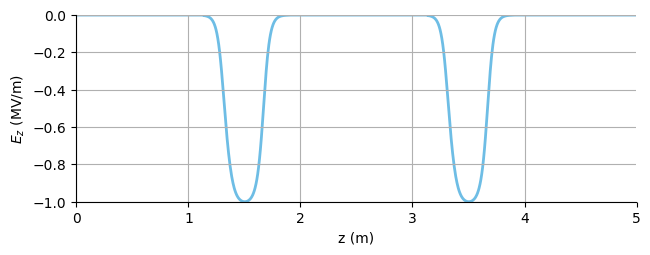

In [8]:
z  = acc.z
hv.Curve((z, acc.Ez(z)), kdims=dim_z, vdims=dim_Ez)

The same procedure is required to define the magnetic field profile $B_z(z)$:

In [9]:
#                 Unique name,  z-position [m],  Bz [T],  Bz(z) profile
acc.add_solenoid('Sol. 1',      1.0,             0.05,   'Bz.dat')
acc.add_solenoid('Sol. 2',      2.0,             0.06,   'Bz.dat')
acc.add_solenoid('Sol. 3',      3.0,             0.07,   'Bz.dat')
acc.add_solenoid('Sol. 4',      4.0,             0.08,   'Bz.dat')

In [10]:
acc.compile()

In [11]:
dim_Bz = hv.Dimension('Bz', unit='Gs', label='$B_z$')

In [12]:
z_Bz = hv.Curve((z, acc.Bz(z)*1e4), kdims=dim_z, vdims=dim_Bz)

:Curve   [z]   (Bz)
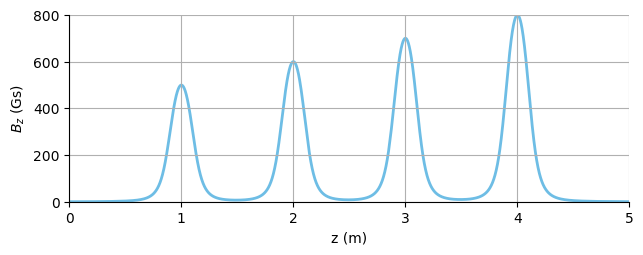

In [13]:
z_Bz

Define the electron beam parameters:

In [14]:
beam = kv.Beam(
    energy = 2,     # MeV
    current = 2e3,  # A
    radius_x = 50e-3, # initial r (m)
    radius_y = 50e-3, # initial r (m)
    radius_xp = 10e-3,     # initial r' (rad)
    radius_yp = 10e-3,     # initial r' (rad)
    #x  = 2.5e-2,   # horizontal centroid position (m)
    xp = 10e-3,     # horizontal centroid angle (rad)
    y = 0,          # vertical centroid position (m)
    normalized_emittance = 1000e-6 # m*rad
)

Now we can run the simulation in order to find the beam envelope:

In [15]:
sim = kv.Simulation(beam, acc)

In [16]:
sim.track()

## Plot the simulation results:

In [17]:
dim_E = hv.Dimension('E', unit='MeV', label='Electron energy', range=(0,None))

:Curve   [z]   (E)
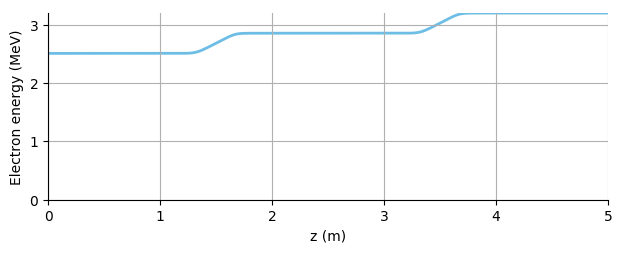

In [18]:
hv.Curve((z, sim.gamma(z)*0.511), kdims=dim_z, vdims=dim_E)

In [19]:
dim_x = hv.Dimension('x', unit='cm', range=(-15,+15))
dim_y = hv.Dimension('y', unit='cm', range=(-15,+15))

Beam centroid:

In [20]:
x = sim.centroid_x # m
z_x = hv.Curve((z, x(z)*100), kdims=dim_z, vdims=dim_x)#.opts(linestyle='--')

:Curve   [z]   (x)
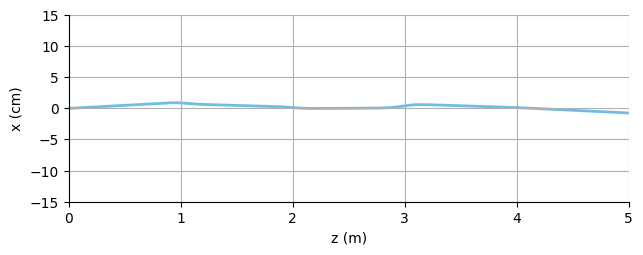

In [21]:
z_x

In [22]:
y = sim.centroid_y # m
z_y = hv.Curve((z, y(z)), kdims=dim_z, vdims=dim_y)#.opts(linestyle='--')

:Curve   [z]   (y)
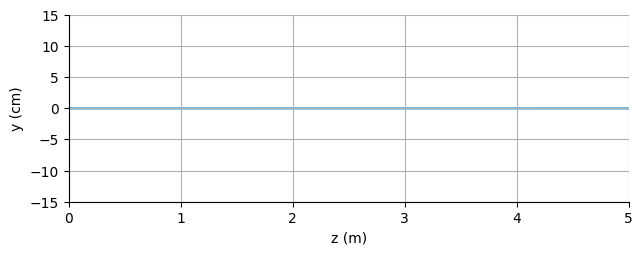

In [23]:
z_y

Beam envelope:

:Layout
   .Overlay.I :Overlay
      .Curve.I  :Curve   [z]   (x)
      .Spread.I :Spread   [x]   (y,yerror)
   .Curve.I   :Curve   [z]   (Bz)
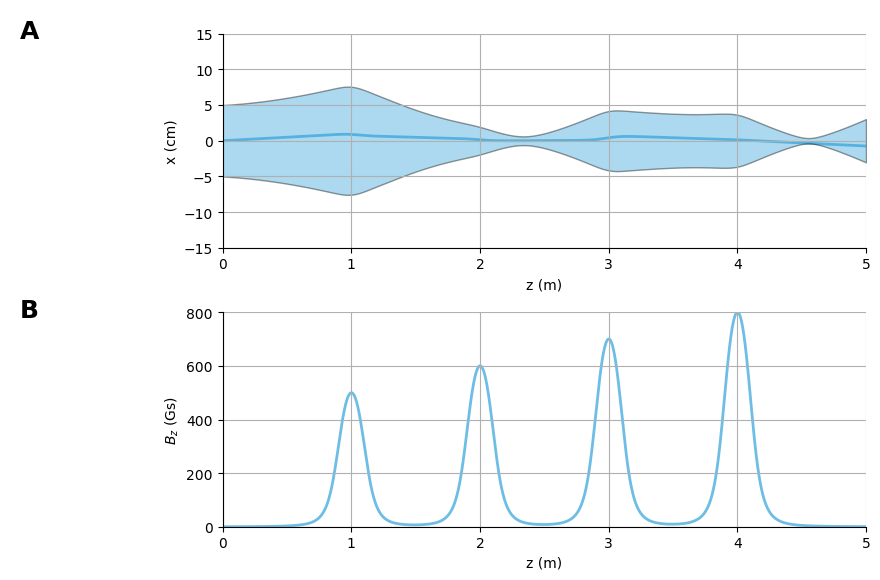

In [24]:
x_size = sim.envelope_x # m
(z_x * hv.Spread((z, 0, x_size(z)*100)) + z_Bz).cols(1)

## Interactive plot

Now we can combine everything into one interactive plot to see the effect of different variables on the beam envelope.

In [25]:
%opts VLine.Solenoid (color='blue' linewidth=10 alpha=0.2)

def x_vs_Bz_plot(solenoid_B_Gs, beam_I):
    #global solenoid2vary
    
    beam.current = beam_I
    acc.Bz_beamline[solenoid2vary].max_field = solenoid_B_Gs/1e4
    
    acc.compile()
    
    sim = kv.Simulation(beam, acc)
    sim.track()
    
    z0_sol = acc.Bz_beamline[solenoid2vary].z0
  
    x = sim.centroid_x # m
    z_x = hv.Curve((z, x(z)*100), kdims=dim_z, vdims=dim_x)#.opts(linestyle='--')
    
    x_size = sim.envelope_x # m
    x_img = z_x * hv.Spread((z, 0, x_size(z)*100))
    
    z_Bz = hv.Curve((z, acc.Bz(z)*1e4), kdims=dim_z, vdims=dim_Bz)

    return (x_img*hv.VLine(z0_sol, group='Solenoid') + z_Bz*hv.VLine(z0_sol, group='Solenoid')).cols(1)

:DynamicMap   [Sol. 1,I]
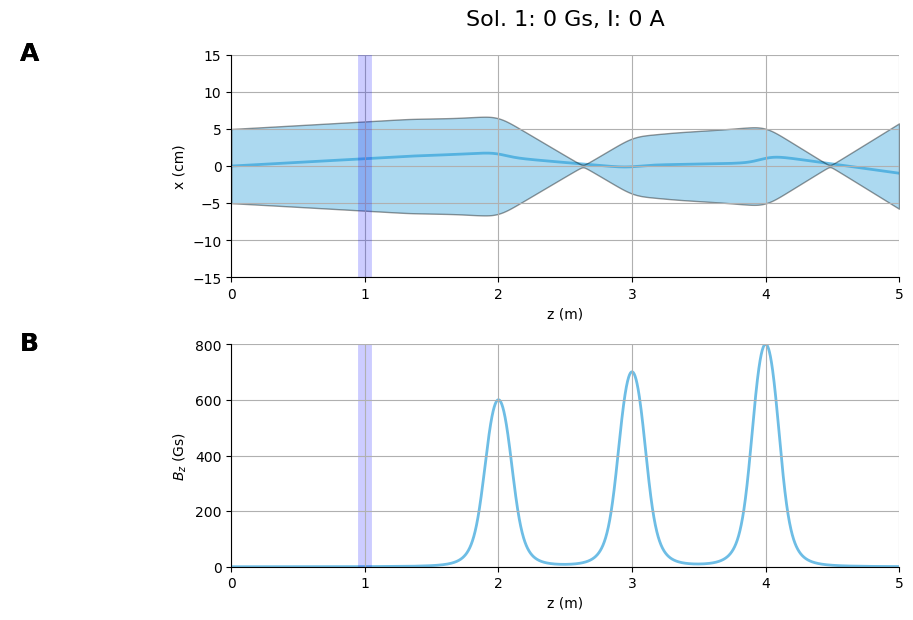

In [26]:
solenoid2vary = 'Sol. 1'

B0 = acc.Bz_beamline[solenoid2vary].max_field # T

dim_sol_B = hv.Dimension(solenoid2vary,  unit='Gs', range=(0, 1000), default=B0*1e4)

dim_I = hv.Dimension("I", unit='A', range=(0, 3000), default=beam.current)

dmap = hv.DynamicMap(x_vs_Bz_plot, kdims=[dim_sol_B, dim_I])
dmap

In [27]:
print(acc)

Accelerator structure.
	Solenoids:
	[ 1.00000 m, 0.00000 T, 'Bz.dat', 'Sol. 1', 0.00000 m, 0.00000 rad, 0.00000 m, 0.00000 rad],
	[ 2.00000 m, 0.06000 T, 'Bz.dat', 'Sol. 2', 0.00000 m, 0.00000 rad, 0.00000 m, 0.00000 rad],
	[ 3.00000 m, 0.07000 T, 'Bz.dat', 'Sol. 3', 0.00000 m, 0.00000 rad, 0.00000 m, 0.00000 rad],
	[ 4.00000 m, 0.08000 T, 'Bz.dat', 'Sol. 4', 0.00000 m, 0.00000 rad, 0.00000 m, 0.00000 rad],
	Accelerating modules:
	[ 1.50000 m, -1.00000 T, 'Ez.dat', 'Acc. 1', 0.00000 m, 0.00000 rad, 0.00000 m, 0.00000 rad],
	[ 3.50000 m, -1.00000 T, 'Ez.dat', 'Acc. 2', 0.00000 m, 0.00000 rad, 0.00000 m, 0.00000 rad],
	Quadrupoles:
	Correctors x:
	Correctors y:



In [28]:
print(beam)

Beam parameters:
	Current	0 A
	Energy	2.000 MeV
	Total momentum	2.458 MeV/c
	Rel. factor	4.914
	Radius x	50.0 mm
	Radius y	50.0 mm
	Radius x prime	10.0 mrad
	Radius y prime	10.0 mrad
	Horizontal centroid position	0.0 mm
	Vertical centroid position	0.0 mm
	Horizontal centroid angle	10.0 mrad
	Vertical centroid angle	0.0 mrad
	Larmor angle	0.0 rad
	Normalized emittance x	1000.0 mm*mrad
	Normalized emittance y	1000.0 mm*mrad

